<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [40]:
'''Base stuff'''
import os
import re

import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import spacy

from collections import Counter

''' Gensim Stuff '''
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import SnowballStemmer

In [41]:
yelp = pd.read_json('./data/review_sample.json', lines=True)

In [42]:
print(yelp.dtypes)
print(yelp.shape)
yelp.head()

business_id            object
cool                    int64
date           datetime64[ns]
funny                   int64
review_id              object
stars                   int64
text                   object
useful                  int64
user_id                object
dtype: object
(10000, 9)


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [43]:
# Dropping a few superfluous columns. Predictive models don't take-in date formats.
yelp = yelp.drop(columns = { 'date', 'useful', 'funny', 'cool'})

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [44]:
''' Tokenizing, cleaning-up preparing for NLP '''
STOPWORDS = set(STOPWORDS).union(set(['the', 'aa', 'aaa', 'aaaaaa' ]))

def tokenize(text): 
    return [token for token in simple_preprocess(text) if token not in STOPWORDS and len(token) >=3]

''' Doing some regex cleaning just for good measure '''
def clean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.replace('\n', '')
    
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [45]:
yelp['tokens'] = yelp['text'].apply(tokenize, clean)
yelp['tokens'].head()

0    [beware, fake, fake, fake, small, business, lo...
1    [came, lunch, togo, service, quick, staff, fri...
2    [vegas, dozens, times, stepped, foot, circus, ...
3    [went, night, closed, street, party, best, act...
4    [stars, bad, price, lunch, seniors, pay, eatin...
Name: tokens, dtype: object

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [46]:
# instantiating my term-frequency inverse document frequency vectorizer object
vect = TfidfVectorizer(stop_words='english')
#creating a list of text documents
text = yelp['tokens'].astype(str)
# tokenizing and building vocab
vect.fit(text)
# transforming text to create feature matrix
dtm = vect.transform(text)

In [47]:
# create pandas dataframe by using sparse matrix above and get_feature_names as columns
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
print('TF-IDF Feature Matrix:')
dtm.head()
# that's cool. some review are in chinese characters.

TF-IDF Feature Matrix:


,aaaahhhs,aaasssk,aabs,aamco,aand,aaron,aback,abandoned,abby,abc,...,覺得店家很用心製作,誓約書にサイン,誰も乗車しなくても,豆腐花,車好きさんには,這是一個不錯的選擇,運転しない,運転中も英語で指導があります,食べ物はうまい,餐後點了甜點
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
''' Building k-nearest neighbors model'''

from sklearn.neighbors import NearestNeighbors

#Instantiate NearestNeighbors model
nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
# Fit NN model to TF-IDF feature matrix
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=10, p=2, radius=1.0)

In [49]:
bad_review = ['''
Came here for brunch with some friends. This place sucks balls. Service and food are terrible. I think we got food poisoning from eating here.
False advertisement. It's also expensive for the quality and amount of food you get. Chips and salsa were free, but chips were stale. Atmosphere
was OK, nothing to brag about. Restroom was not clean.
''']

In [50]:
# transforming KNN model using a FAKE (bad) review and finding its 10 nearest neighbors
new = vect.transform(bad_review)
a = nn.kneighbors(new.todense())

In [51]:
a[0:10]

(array([[1.22493419, 1.22740365, 1.22958236, 1.23266897, 1.2413283 ,
         1.24175678, 1.25932721, 1.26179168, 1.26200716, 1.26510681]]),
 array([[8759, 5796, 3230,  529, 9283, 7953, 9030, 3466, 2161, 3356]]))

In [52]:
print(yelp['text'].iloc[8759])
# yay nearest neighbors model is working...returns 10 nearest bad reviews! 
# what I noticed, however, is that the model becomes worse at finding nearest/similar
# reviews down the list of neighbors. For example, while the first 4 nearest reviews are 
# consistently negative/lukewarm reviews just like my fake review, the fifth review [7953] is
# actually a "good" review. Nearest Neighbors model has diminishing returns down the list of
# neighbors.

False Advertisement: hours of operation are false. My boyfriend & I went in one night around 1 am  we got the AYCE & within half an hour they said last call!!! Wth your bright lights outside said til 4 am! The food was 'alright & as we were finishing up the waitress asked for the tip! Really!? Who does that!!?


In [53]:
print(yelp['text'].iloc[5796])
print(end="\n")
print(yelp['text'].iloc[3230])
print(end="\n")
print(yelp['text'].iloc[529])
print(end="\n")
print(yelp['text'].iloc[9283])
print(end="\n")
print(yelp['text'].iloc[7953])

My friend and I had dinner here last night, and now I'm calling out of work because I have food poisoning; I feel like death. Sucks because the food did taste really good.

This place just sucks. Food was terrible. Service was even worse some how. Just skip it all together.

Blah! Was craving a breakfast burrito this morning & the place I usually go to was still closed so decided to try Filiberto's since its just down the road. Got the Bacon burrito but was disappointed to see that there was no potatoes, just eggs, bacon, & cheese. It was warm & prepared quickly but it still had no flavor. The red sauce they give out was pretty bad. Asked for chips & salsa & got a big box of chips with pico de gallo on it. The pico wasn't good & just made the chips soggy. The chips were ok. I won't be coming here again, next time I'll make my own breakfast burrito at home. Now I'm just hoping I don't come down with food poisoning which was one of the reasons I avoided this place but I was desperate.

V

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [54]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(yelp, train_size=0.80, random_state=69)

//anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [55]:
val.head()

,business_id,review_id,stars,text,user_id,tokens
5256,SkG_g2OXQENIojm0Gz6YJg,VzFLhFzfDgRTrBb028iHAA,2,This place is super cute. You can tell they pu...,6EGqHVa7QAVOSx5ufxtzHA,"[place, super, cute, tell, money, making, invi..."
7272,BfIcrMq0Me0D7BBSYij7Fg,3zWv1eO8bBICegjz5Nzc4g,1,We use to love this ice cream place. Recently...,aXOWGk7TMA3VmyYtHfM-3Q,"[use, love, ice, cream, place, recently, order..."
1323,939j88ceB05Te3D7kQPwSA,tSGQ1ZHm_KA1zyY0MgBkHA,5,"We came here on a Friday night, after midnight...",rHgT6lBbZ2PaHt0UWfTMtw,"[came, friday, night, midnight, vcard, granted..."
4924,RQ-dOd7rGVwlan2RJ2Q5mw,cJRF9miR8q_q99f5ipqO3Q,5,"Great service, great people.\n\nEd, Mitch and ...",hidreIiJx1ipK3O7n0148w,"[great, service, great, people, mitch, crew, k..."
5845,FaDLsN7VzLmtZVl-6deqwQ,_2L8qbHmzOtDXxY7qE_TUQ,1,"Love my provider, Dr Cropp, however the patien...",vbLcdh4_vCA6kO59h0nu_A,"[love, provider, cropp, patient, services, ext..."


In [59]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

vect = TfidfVectorizer(stop_words='english')
clf = SGDClassifier(alpha=0.0001, 
                    average=False, 
                    early_stopping=False,
                    epsilon=0.1,
                    eta0=0.01, 
                    fit_intercept=True, 
                    l1_ratio=0.15,
                    learning_rate='adaptive', 
                    loss='squared_loss', 
                    max_iter=1000,
                    n_iter_no_change=42, 
                    penalty='l2', 
                    power_t=0.25, 
                    random_state=69,
                    shuffle=True, 
                    tol=0.001, 
                    validation_fraction=0.1, 
                    verbose=0,
                    warm_start=False)

pipe = Pipeline([('vect', vect), ('clf', clf)])

# Fit Pipeline
pipe.fit(train['tokens'].astype(str), train['stars'].astype(str))

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...om_state=69, shuffle=True,
       tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False))])

In [60]:
from sklearn.model_selection import GridSearchCV

# Declaring parameters to fine tune
parameters = {
    #'clf__alpha' : (.0001),
    #'clf__max_iter' : (1000),
    'clf__n_iter_no_change' : (45, 50),
    #'clf__learning_rate' : ('constant', 'optimal', 'invscaling', 'adaptive'),
    #'clf__tol' : (.001, .002, .01, .1),
    #'clf__loss' : ('squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'),
    #'clf__penalty' : ('none', 'l2', 'l1', 'elasticnet'),
    #'clf__n_estimators' : (10, 20)
    

}

# Instantiating Grid Search
grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=4, verbose=1)

# Fitting to find best fit
grid_search.fit(train['tokens'].astype(str), train['stars'].astype(str))

# Printing out the best params along with the best accuracy score via grid search
print(grid_search.best_params_, grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   28.5s finished


{'clf__n_iter_no_change': 45} 0.607125


In [61]:
# making a star rating prediction for my bad review
pred = grid_search.predict(bad_review)

In [62]:
pred
# my model predicts a 1 star review for my bad review. that's pretty good, I think!

array(['1'], dtype='<U1')

In [67]:
# Predictions on validation sample and Accuracy score
from sklearn.metrics import accuracy_score

pred = grid_search.predict(val['tokens'].astype(str))
accuracy = accuracy_score(val['stars'].astype(str), pred)
print(f'Validation Accuracy Score: {accuracy}')
# Not a great accuracy score, which speaks to the fact of how hard it is to predict/interpret
# natural language.

Validation Accuracy Score: 0.594


## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Keep the `iterations` parameter at or below 5 to reduce run time
    - The `workers` parameter should match the number of physical cores on your machine.
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [104]:
from gensim.models import LdaMulticore
from gensim import corpora
from gensim.corpora import Dictionary

Learn the vocubalary of the yelp data:

In [105]:
# a dictionary representation of all the words in our corpus
id2word = corpora.Dictionary(yelp['tokens'])
# let's do some filtering by removing extreme values from the dataset
id2word.filter_extremes(no_below=.15, no_above=.85)

Create a bag of words representation of the entire corpus

In [106]:
corpus = [id2word.doc2bow(text) for text in yelp['tokens']]

Your LDA model should be ready for estimation: 

In [107]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   iterations=1,
                   workers=4,
                   num_topics = 10 # You can change this parameter
                  )

//anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
//anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
//anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * log

Create 1-2 visualizations of the results

In [108]:
lda.print_topics()

[(0,
  '0.010*"place" + 0.010*"great" + 0.010*"food" + 0.009*"good" + 0.009*"service" + 0.008*"like" + 0.007*"time" + 0.004*"got" + 0.004*"ordered" + 0.003*"best"'),
 (1,
  '0.010*"great" + 0.010*"food" + 0.010*"place" + 0.009*"good" + 0.007*"time" + 0.007*"service" + 0.006*"like" + 0.005*"came" + 0.005*"got" + 0.004*"nice"'),
 (2,
  '0.009*"place" + 0.009*"good" + 0.009*"food" + 0.008*"great" + 0.007*"time" + 0.007*"service" + 0.006*"like" + 0.004*"went" + 0.004*"try" + 0.004*"staff"'),
 (3,
  '0.010*"food" + 0.009*"great" + 0.009*"place" + 0.008*"good" + 0.008*"service" + 0.008*"like" + 0.007*"time" + 0.005*"got" + 0.005*"best" + 0.004*"love"'),
 (4,
  '0.012*"good" + 0.010*"service" + 0.009*"food" + 0.008*"place" + 0.008*"great" + 0.007*"like" + 0.006*"time" + 0.005*"got" + 0.004*"love" + 0.004*"order"'),
 (5,
  '0.011*"place" + 0.010*"good" + 0.010*"food" + 0.009*"like" + 0.007*"time" + 0.007*"great" + 0.007*"service" + 0.005*"best" + 0.004*"got" + 0.004*"went"'),
 (6,
  '0.010*"gr

In [109]:
''' Printing out topics cleaned up Version '''

words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for id, t in enumerate(topics): 
    print(f" ------ Topic {id} ------")
    print(t, end="\n\n")
# from the top10 topics we observe a handful of recurrent topics: "service", "food", "good", and "great".

 ------ Topic 0 ------
place great food good service

 ------ Topic 1 ------
great food place good time

 ------ Topic 2 ------
place good food great time

 ------ Topic 3 ------
food great place good service

 ------ Topic 4 ------
good service food place great

 ------ Topic 5 ------
place good food like time

 ------ Topic 6 ------
great food good place like

 ------ Topic 7 ------
food place good great time

 ------ Topic 8 ------
place good food like great

 ------ Topic 9 ------
great good food service place



In [111]:
''' This is very useful for finding words that arent useful to the overall analysis '''
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

//anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.000352  0.002245       1        1  10.037468
7     -0.002833 -0.002363       2        1  10.030587
5     -0.002240  0.000099       3        1  10.028238
3      0.000802  0.000221       4        1  10.027669
9      0.002075  0.000629       5        1   9.996923
8     -0.002493  0.002768       6        1   9.993579
6      0.001411 -0.001473       7        1   9.979958
1     -0.000135 -0.002392       8        1   9.979628
2      0.001744 -0.001033       9        1   9.964704
0      0.001316  0.001299      10        1   9.961246, topic_info=     Category         Freq        Term        Total  loglift  logprob
131   Default  4559.000000       place  4559.000000  30.0000  30.0000
115   Default  1431.000000        went  1431.000000  29.0000  29.0000
36    Default  1439.000000        came  1439.000000  28.0000  28.0000
44    Default  3500.000000     service  3500.000000  27.0000  27.0000
206   Default  4130.000000       great  4130.000000  26.0000  26.0000
142   Default  4751.000000        food  4751.000000  25.0000  25.0000
45    Default  1506.000000       staff  1506.000000  24.0000  24.0000
17    Default  3328.000000        like  3328.000000  23.0000  23.0000
724   Default  1587.000000        love  1587.000000  22.0000  22.0000
114   Default   879.000000       vegas   879.000000  21.0000  21.0000
346   Default  1403.000000        come  1403.000000  20.0000  20.0000
39    Default  4455.000000        good  4455.000000  19.0000  19.0000
334   Default   658.000000     awesome   658.000000  18.0000  18.0000
306   Default  1400.000000         try  1400.000000  17.0000  17.0000
120   Default  1749.000000        best  1749.000000  16.0000  16.0000
93    Default   941.000000       night   941.000000  15.0000  15.0000
35    Default   940.000000        wait   940.000000  14.0000  14.0000
640   Default  1331.000000  restaurant  1331.000000  13.0000  13.0000
133   Default   777.000000       table   777.000000  12.0000  12.0000
376   Default  1372.000000      little  1372.000000  11.0000  11.0000
471   Default  1174.000000        know  1174.000000  10.0000  10.0000
91    Default  1686.000000        nice  1686.000000   9.0000   9.0000
155   Default   873.000000       price   873.000000   8.0000   8.0000
304   Default   604.000000       thing   604.000000   7.0000   7.0000
129   Default  1383.000000      people  1383.000000   6.0000   6.0000
1251  Default  1487.000000     ordered  1487.000000   5.0000   5.0000
382   Default  1448.000000       order  1448.000000   4.0000   4.0000
15    Default   594.000000        left   594.000000   3.0000   3.0000
523   Default   628.000000      wanted   628.000000   2.0000   2.0000
190   Default  1312.000000     amazing  1312.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
636   Topic10    66.875977     perfect   532.067261   0.2325  -6.5580
432   Topic10    96.649864    customer   798.948425   0.1943  -6.1897
163   Topic10   100.697472       think   844.051819   0.1804  -6.1487
83    Topic10    62.744884        line   502.552368   0.2258  -6.6217
39    Topic10   444.925110        good  4455.249512   0.0025  -4.6629
142   Topic10   458.007874        food  4751.816895  -0.0329  -4.6339
182   Topic10   127.686691   recommend  1121.864868   0.1333  -5.9112
33    Topic10   329.959564        time  3302.503418   0.0030  -4.9619
154   Topic10   116.971680      pretty  1021.318970   0.1395  -5.9989
354   Topic10   132.395599   delicious  1194.478882   0.1068  -5.8750
668   Topic10    77.833687   excellent   643.363770   0.1943  -6.4063
1052  Topic10   122.980194         new  1117.253662   0.0999  -5.9488
205   Topic10   119.115227       going  1106.939209   0.0772  -5.9807
525   Topic10   101.630623        work   906.891479   0.1178  -6.1395
93    Topic10   104.140030       night   941.197754   0.1051  -6.1151
74    Topic10   182

In [ ]:
# From the visualization above, topics have the following top3 word components:
# topic 1: good, service, food
# topic 2: food, place, good
# topic 3: place, good, food

# again, "service", "food" and overall "good/great" make the majority of topics.

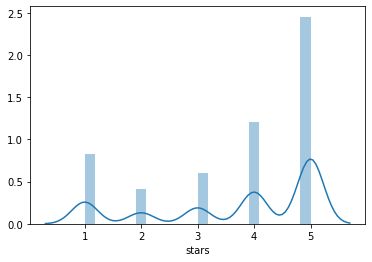

In [97]:
''' Visualizing the distribution of Star Ratings '''
sns.distplot(yelp['stars']);
# the majority of star ratings in the yelp dataset corresponds to 5 star ratings, which
# skews our analysis towards better reviews. We must control for this.

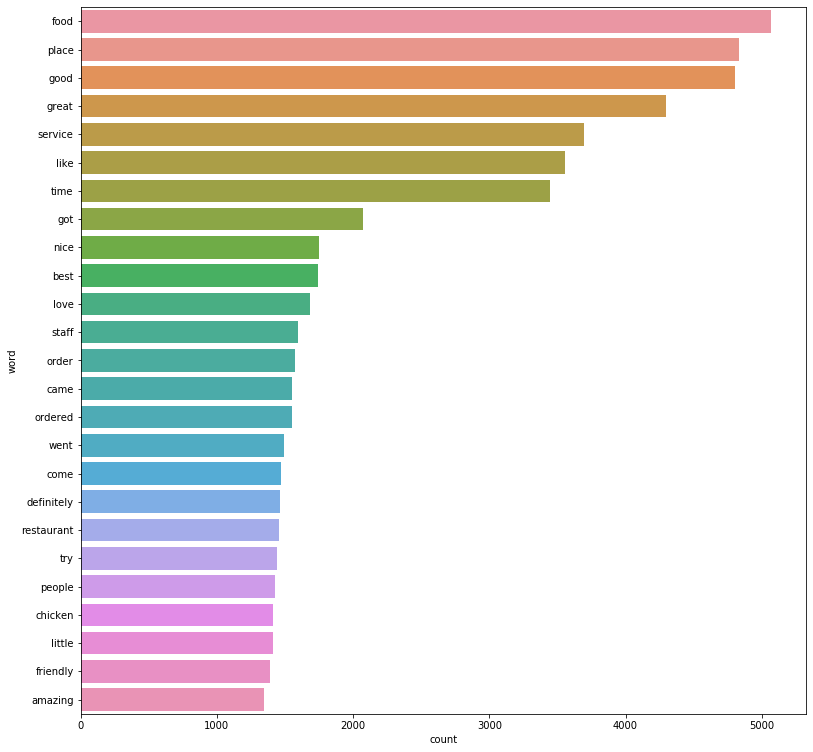

In [99]:
''' Visualizing the most used diction in the data  '''

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')
    
    
wc = count(yelp['tokens'])

sns.barplot(x='count', y='word', data = (wc[wc['count'] > 1300]))
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 13

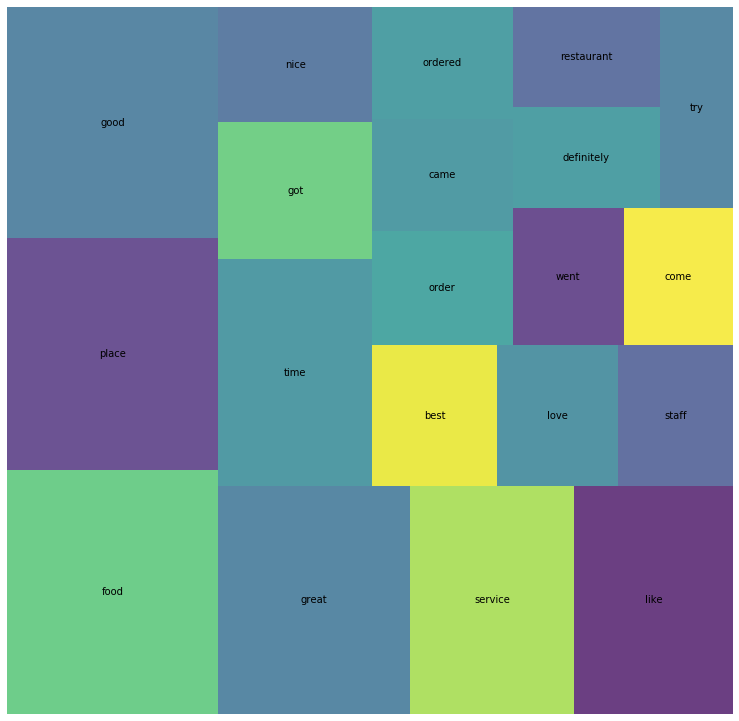

In [100]:
import squarify

# Overall token counts
wc_top20 = wc[wc['rank'] <= 20 ]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.axis('off')
plt.show()

In [101]:
yelp.head()

,business_id,review_id,stars,text,user_id,tokens
0,nDuEqIyRc8YKS1q1fX0CZg,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",n1LM36qNg4rqGXIcvVXv8w,"[beware, fake, fake, fake, small, business, lo..."
1,eMYeEapscbKNqUDCx705hg,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,5CgjjDAic2-FAvCtiHpytA,"[came, lunch, togo, service, quick, staff, fri..."
2,6Q7-wkCPc1KF75jZLOTcMw,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,BdV-cf3LScmb8kZ7iiBcMA,"[vegas, dozens, times, stepped, foot, circus, ..."
3,k3zrItO4l9hwfLRwHBDc9w,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,cZZnBqh4gAEy4CdNvJailQ,"[went, night, closed, street, party, best, act..."
4,6hpfRwGlOzbNv7k5eP9rsQ,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",n9QO4ClYAS7h9fpQwa5bhA,"[stars, bad, price, lunch, seniors, pay, eatin..."


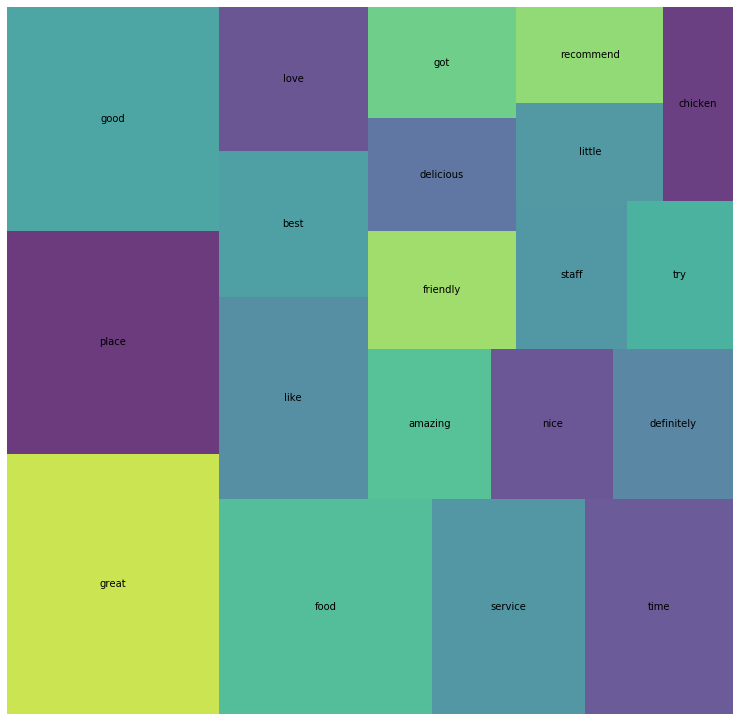

In [102]:
# let's look at the word counts by star ratings
# a good shop has a rating of 4 or 5
wc_good = count(yelp[yelp['stars'] >= 4]['tokens'])
wc_top20_good = wc_good[wc_good['rank'] <= 20 ]

squarify.plot(sizes=wc_top20_good['pct_total'], label=wc_top20_good['word'], alpha=.8)
plt.axis('off')
plt.show()
# we see in our analysis that highly rated places are associated with or described by the words
# "love", "delicious", "friendly", "amazing food", which seems appropriate for a well-rated establishment.

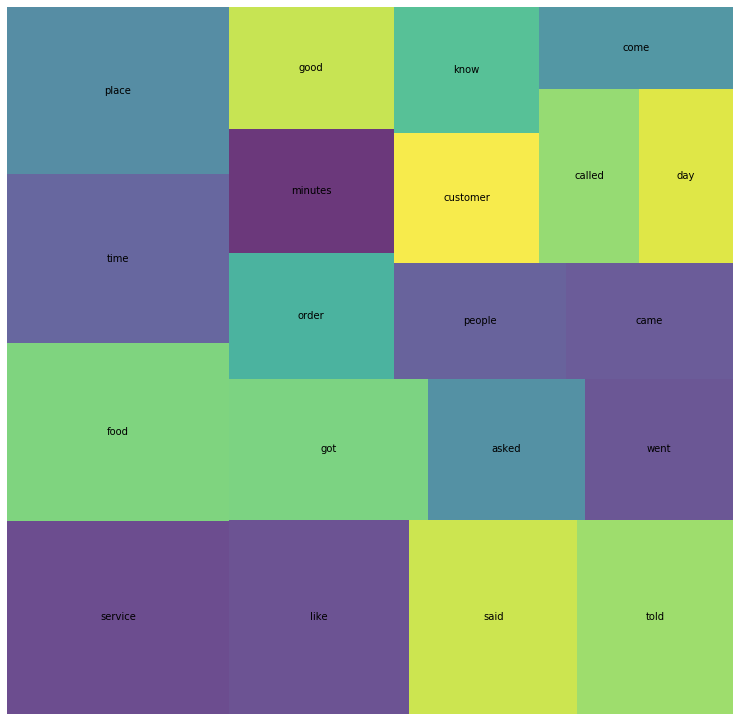

In [112]:
wc_bad = count(yelp[yelp['stars'] < 2 ]['tokens'])
wc_top20_bad = wc_bad[wc_bad['rank'] <= 20]

squarify.plot(sizes=wc_top20_bad['pct_total'], label=wc_top20_bad['word'], alpha=.8)
plt.axis('off')
plt.show()
#on the other hand, poorly-rated places are described by reviewers by their engagement with staff
# having "asked" a question and been "told" a response. Also, concern about "service" is at the forefront of
# their description. Other concerns are related to time: "time", "minutes", 

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)